<a href="https://colab.research.google.com/github/MuhammedAshraf2020/BreastCancerHist/blob/main/BreastCanceripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/Drive")

Mounted at /content/Drive


# Import libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale , resize
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras
from keras.preprocessing.image  import ImageDataGenerator
from keras.layers    import Flatten,Dense,Dropout,BatchNormalization
from keras.models    import Model , Sequential
from keras.utils     import to_categorical
from keras.layers    import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import  EarlyStopping , ModelCheckpoint
from keras.regularizers import l2
import shutil

# Create Data Folder

In [ ]:
cp -r "/content/Drive/MyDrive/BreaKHis_v1/histology_slides/breast" "/content/"

In [ ]:
code = {0:"Adenosis" , 1 : "Fibroadenoma" , 2 :"Phyllodes Tumor" , 3 : "Tubular Adenoma",  4 : "Ductal Carcinoma",  5 : "Lobular Carcinoma" , 6 : "Mucinous Carcinoma" , 7:"Papillary Carcinoma" }

In [ ]:
for i in range(8):
  os.system("mkdir /content/data/{}".format(code[i]))

In [ ]:
main_classes = ["benign" , "malignant"]
folder_path = "/content/breast"
data_path = "/content/data"

folders = os.listdir(data_path)
clss = -1
for mc in main_classes:
  path = os.path.join(folder_path , mc) + "/SOB"
  for cls in os.listdir(path):
    clss += 1
    cls_path  = path + "/" + cls
    for folder in tqdm(os.listdir(cls_path)):
      file_path = cls_path + "/" + folder + "/100X"
      for img in os.listdir(file_path): 
        img_path = os.path.join(file_path , img)
        target_path = data_path + "/" + folders[clss]
        shutil.move( img_path , target_path)

100%|██████████| 38/38 [00:00<00:00, 1010.48it/s]


# Show Sample of images (8 classes)

In [ ]:
main_path = "/content/data"
sample = []
edges  = []
for Class in os.listdir(main_path):
  path = os.path.join(main_path , Class)
  img_path = path + "/" + os.listdir(path)[0]
  sample.append(cv2.imread(img_path))
  edges.append(cv2.Canny(cv2.imread(img_path , 0) , 100 , 200))

In [ ]:
sample = np.array(sample)

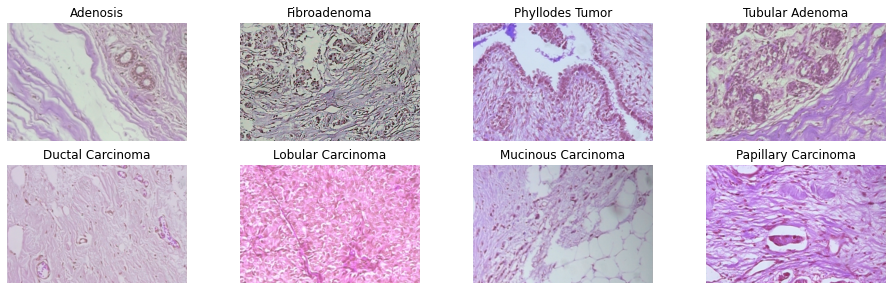

In [ ]:
plt.figure(figsize = (16 , 10))
for n , i in enumerate(range(8)):
    plt.subplot(4 , 4 , n +1)
    plt.imshow(sample[i])
    plt.axis("off")
    plt.title(code[i])

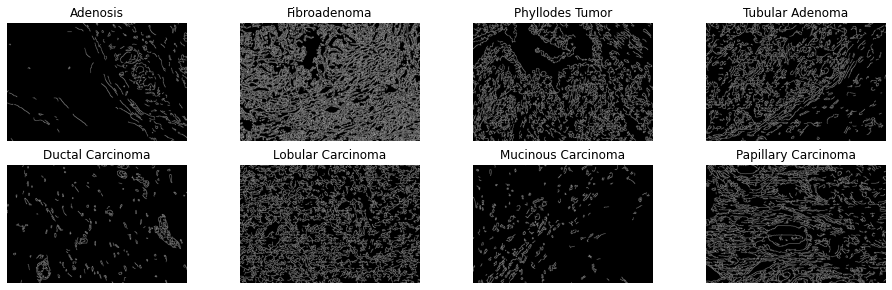

In [ ]:
plt.figure(figsize = (16 , 10))
for n , i in enumerate(range(8)):
    plt.subplot(4 , 4 , n +1)
    plt.imshow(edges[i] , "gray")
    plt.axis("off")
    plt.title(code[i])

# Create Train Test Val images

In [ ]:
main_path = "/content/data"
X = []
y = []
clss = -1
for Class in os.listdir(main_path):
  path = os.path.join(main_path , Class)
  clss +=1
  for img in tqdm(os.listdir(path)):
    img_path = os.path.join(path , img)
    img = cv2.imread(img_path) / 255.0
    img = cv2.resize(img , (224 , 224))
    X.append(img)
    y.append(clss)

100%|██████████| 903/903 [00:09<00:00, 91.56it/s]


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print("X shape : " , X.shape)
print("y classes : " , np.unique(y))

X shape :  (2081, 224, 224, 3)
y classes :  [0 1 2 3 4 5 6 7]


In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.15)

In [ ]:
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.10)

In [ ]:
print("train data size = {}".format(X_train.shape))
print("test  data size = {}".format(X_test.shape))
print("val   data size = {}".format(X_val.shape))

train data size = (1591, 224, 224, 3)
test  data size = (313, 224, 224, 3)
val   data size = (177, 224, 224, 3)


In [ ]:
y_train = to_categorical(y_train , num_classes = 8)
y_test = to_categorical(y_test , num_classes = 8)
y_val = to_categorical(y_val , num_classes = 8)

In [ ]:
print("train labels size = {} with classes {}".format(y_train.shape , np.unique(np.argmax(y_train , axis = 1))))
print("test  labels size = {} with classes {}".format(y_test.shape  , np.unique(np.argmax(y_test  , axis = 1))))
print("val   labels size = {} with classes {}".format(y_val.shape   , np.unique(np.argmax(y_val   , axis = 1))))

train labels size = (1591, 8) with classes [0 1 2 3 4 5 6 7]
test  labels size = (313, 8) with classes [0 1 2 3 4 5 6 7]
val   labels size = (177, 8) with classes [0 1 2 3 4 5 6 7]


# Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=90,  
        zoom_range = 0.2,
        horizontal_flip=True,  
        vertical_flip = True)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(
        rotation_range =90,  
        zoom_range = 0.2, 
        horizontal_flip = True,  
        vertical_flip = True)

val_datagen.fit(X_val)

# Build Model

In [ ]:
base_model = keras.applications.DenseNet121(weights="imagenet", include_top=False,
	input_tensor= keras.layers.Input(shape=(224, 224, 3)))

In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024 ,activation='relu', kernel_regularizer=l2(l=0.03)))
model.add(Dropout(0.5))
model.add(Dense(128 , activation='relu', kernel_regularizer=l2(l=0.03)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(8,activation='softmax'))


# Set Callbacks

In [ ]:
callback = [ModelCheckpoint("/content/checkpoint2" ,
                                            monitor='val_accuracy', mode='max', 
                                            save_best_only=True) ,
            EarlyStopping(monitor='val_accuracy' , patience = 12)]

# Model fitting

In [ ]:
model.compile( optimizer=keras.optimizers.Adam(lr = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist = model.fit(train_datagen.flow(X_train , y_train , batch_size = 16) , validation_data = val_datagen.flow(X_val , y_val , batch_size = 16) , epochs = 20 , callbacks = callback)

Epoch 1/20
100/100 [==============================] - 25s 249ms/step - loss: 1.1040 - accuracy: 0.9302 - val_loss: 1.2507 - val_accuracy: 0.8475
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 2/20
100/100 [==============================] - 25s 247ms/step - loss: 1.0285 - accuracy: 0.9340 - val_loss: 1.0065 - val_accuracy: 0.9096
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 3/20
100/100 [==============================] - 25s 247ms/step - loss: 0.9713 - accuracy: 0.9290 - val_loss: 0.9712 - val_accuracy: 0.8814
Epoch 4/20
100/100 [==============================] - 25s 247ms/step - loss: 0.8767 - accuracy: 0.9441 - val_loss: 1.0376 - val_accuracy: 0.9153
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 5/20
100/100 [==============================] - 25s 246ms/step - loss: 0.8515 - accuracy: 0.9277 - val_loss: 1.0326 - val_accuracy: 0.8701
Epoch 6/20
100/100 [==============================] - 25s 248ms/step - loss: 0.7927 - 

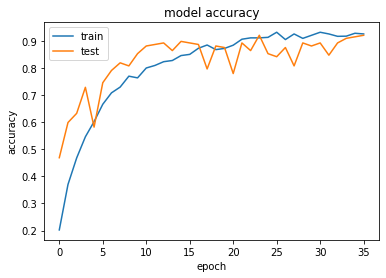

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

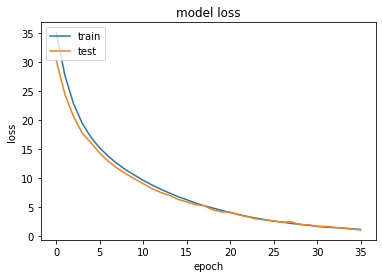

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test , y_test)

10/10 [==============================] - 6s 248ms/step - loss: 0.5444 - accuracy: 0.8978


[0.5443771481513977, 0.8977635502815247]

In [ ]:
model_checked = keras.models.load_model("/content/checkpoint2")

In [ ]:
model_checked.evaluate(X_test , y_test)

10/10 [==============================] - 4s 141ms/step - loss: 0.4700 - accuracy: 0.9105


[0.4700302183628082, 0.9105431437492371]